In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [4]:
pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#conda install torchvision==0.8.2 -c pytorch

In [5]:
!pip install --upgrade kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 517 kB 33.1 MB/s 


In [6]:
pip install allennlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 729 kB 35.2 MB/s 
     |████████████████████████████████| 1.8 MB 56.8 MB/s 
     |████████████████████████████████| 297 kB 90.4 MB/s 
     |████████████████████████████████| 4.1 MB 75.6 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 106 kB 72.6 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 880 kB 52.2 MB/s 
     |████████████████████████████████| 21.0 MB 1.5 MB/s 
     |████████████████████████████████| 1.0 MB 68.0 MB/s 
     |████████████████████████████████| 298 kB 53.2 MB/s 
     |████████████████████████████████| 592 kB 63.5 MB/s 
     |████████████████████████████████| 248 kB 59.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing whee

In [7]:
!pip install --upgrade fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 28.8 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.7
    Uninstalling fastai-2.7.7:
      Successfully uninstalled fastai-2.7.7


In [8]:
!pip list

Package                       Version
----------------------------- ----------------------------
absl-py                       1.2.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
allennlp                      2.10.0
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
base58                        2.1.1
beautifulsoup4                4.6

In [9]:

import fastai; fastai.__version__

'2.7.8'

In [10]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io


In [11]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [12]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename))


df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)


,dirname,filename
0,/content/drive/MyDrive/liver-tumor-segmentation,.DS_Store
243,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt4/sample_data,README.md
242,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt4/sample_data,anscombe.json
244,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt4/sample_data,california_housing_test.csv
245,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt4/sample_data,california_housing_train.csv
...,...,...
227,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-95.nii
228,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-96.nii
229,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-97.nii
230,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-98.nii


In [13]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/drive/MyDrive/liver-tumor-segmentation/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files
#df_files_test

131


,dirname,filename,mask_dirname,mask_filename
0,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-0.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-1.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-10.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-100.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-101.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-95.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-96.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-97.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-98.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [14]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [15]:
# Read sample
sample = 3
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 685)
(512, 512, 685)
/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6/volume-100.nii


In [16]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-1024.0 3071.0
0.0 2.0


In [18]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

## Plot a image

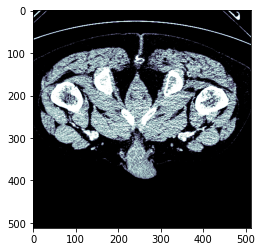

In [19]:
plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [20]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

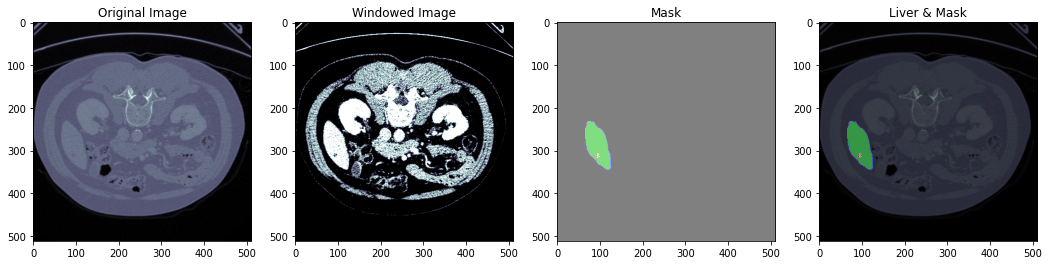

In [24]:
sample=410 # this is bscically the slice
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

(512, 512)
[[     0 257907]
 [     1   4173]
 [     2     64]]


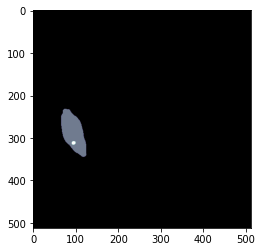

In [25]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
print(mask.shape)
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)
plt.imshow(mask , cmap = 'bone')

In [26]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

## Test plot

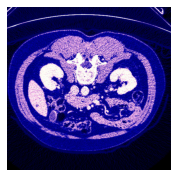

In [27]:
_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [28]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h
slice_sum=0
if (GENERATE_JPG_FILES):
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files))): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim
        slice_sum = slice_sum+curr_dim
        
        for curr_slice in range(0,curr_dim,1): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
            
else:
    
    path = Path("/content/drive/MyDrive/liver-tumor-segmentation/images") # read jpg from saved kernel output
print(slice_sum)

  0%|          | 0/131 [00:00<?, ?it/s]

58638


# MODEL TRAINING

In [29]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): 
    return fname

def label_func(x): 
    return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

# ../output/kaggle/working/train_images.zip
# ds = db.datasets(source=path/'train_images.zip')
ds = db.datasets(source='/content/train_images')
print(len(ds))
print(ds)

58638
(#58638) [(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)...]


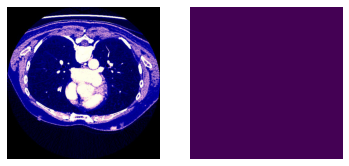

In [30]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [31]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 262144]]


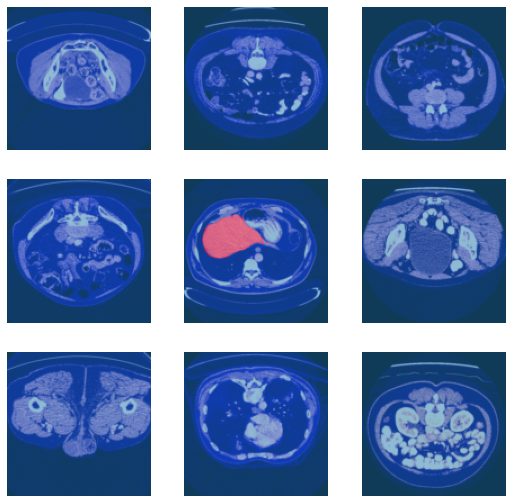

In [32]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

In [ ]:
import tensorflow as tf


In [41]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

def dice_coef(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    y_true_f = tf.reshape(tf.dtypes.cast(inp, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(trag, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
#def dice_coef(inp, targ):
#    y_true_f = K.flatten(inp)
 #   y_pred_f = K.flatten(targ)
  #  intersection = K.sum(y_true_f * y_pred_f)
   # return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#def dice_coef_loss(inp, targ):
    #return -dice_coef(inp, targ)

In [42]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc])

SuggestedLRs(valley=5.248074739938602e-05)

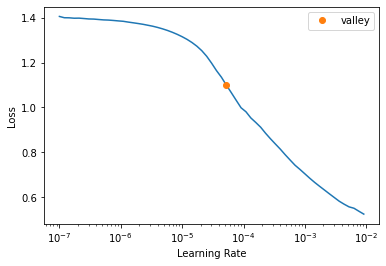

In [43]:
learn.lr_find()

In [44]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.006767,0.005614,0.939551,0.997965,10:08


Better model found at epoch 0 with valid_loss value: 0.005613578483462334.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.003674,0.003818,0.963599,0.998537,10:59
1,0.004420,0.003915,0.967017,0.998501,11:01
2,0.002813,0.002953,0.973998,0.998816,11:02
3,0.002305,0.002493,0.975987,0.998985,11:03
4,0.002114,0.002357,0.975101,0.999039,11:03


Better model found at epoch 0 with valid_loss value: 0.0038178344257175922.
Better model found at epoch 2 with valid_loss value: 0.002952893730252981.
Better model found at epoch 3 with valid_loss value: 0.0024933491367846727.
Better model found at epoch 4 with valid_loss value: 0.002356856595724821.


In [56]:
learn.predict(imgs[0])

(TensorMask([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), TensorBase([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), TensorBase([[[9.9998e-01, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 9.9999e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 9.9999e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [9.9999e

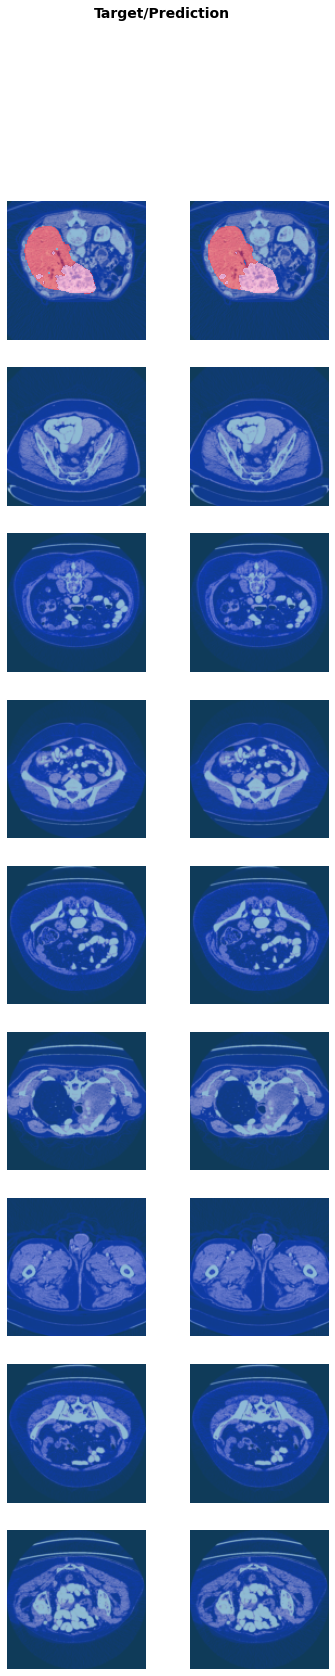

In [57]:
learn.show_results()

In [58]:
# Save the model
learn.export(path/f'Liver_segmentation')

In [59]:
import gc
del learn
gc.collect()
torch.cuda.empty_cache()

# TESTING MODEL

### Run this cell to do the required imports

In [60]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image


import fastai; 
print(fastai.__version__)
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

2.7.8


#### Run this cell to make sure the data files are loaded into a variable called as `df_files` (it has to a pandas dataframe) This cell also defines the function required for nii file format conversion

### Use the below cell to split the dataset into test and train. This assumes that the same split was used for training the model and the model has not seen the test datas

In [61]:
# df_files=df_files[100:131]
# df_files

# first 20 data points
df_file = df_files[0:20]
df_file

,dirname,filename,mask_dirname,mask_filename
0,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-0.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-1.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt1,volume-10.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt6,volume-100.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-101.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-101.nii
5,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-102.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-102.nii
6,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-103.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-103.nii
7,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-104.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-104.nii
8,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-105.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-105.nii
9,/content/drive/MyDrive/liver-tumor-segmentation/volume_pt8,volume-106.nii,/content/drive/MyDrive/liver-tumor-segmentation/segmentations,segmentation-106.nii


### Below cell imports the trained model and also defines a few variables and functions required for the tetsing.
**Make sure you define the path as per your system**

Definning things required for loading the model

In [62]:
# Load saved model
bs = 16
im_size = 128

# the labels used for the classes
# When predicting the model predicts it in terms of indices (ie 0 --> background, 1 --> liver ...)
codes = np.array(["background","liver","tumor"])

# the default pathb
path = './'

def get_x(fname:Path): 
    return fname

def label_func(x): 
    return path/'train_masks'/f'{x.stem}_mask.png'

def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

## Loading the model

In [63]:
# loading the tensor flow model
tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
learn0 = load_learner('/content/Liver_segmentation',cpu=False )
learn0.dls.transform = tfms

### Below function helps to convert the nii file to the format used by the model. So that prediction is possible

In [64]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
#     for curr_slice in range(curr_dim):
#         data = tensor(test_nii[...,curr_slice].astype(np.float32))
#         data = (data.to_nchan(wins)*255).byte()
#         slices.append(TensorImage(data))
        
#     return slices
    data = tensor(test_nii[...,450].astype(np.float32))
    data = (data.to_nchan(wins)*255).byte()
    slices.append(TensorImage(data))
#     data = tensor(test_nii[...,351].astype(np.float32))
#     data = (data.to_nchan(wins)*255).byte()
#     slices.append(TensorImage(data))
    print(slices)
    return slices

### Selecting the test number and the slice number for which the prediction is to be done

(512, 512, 685)


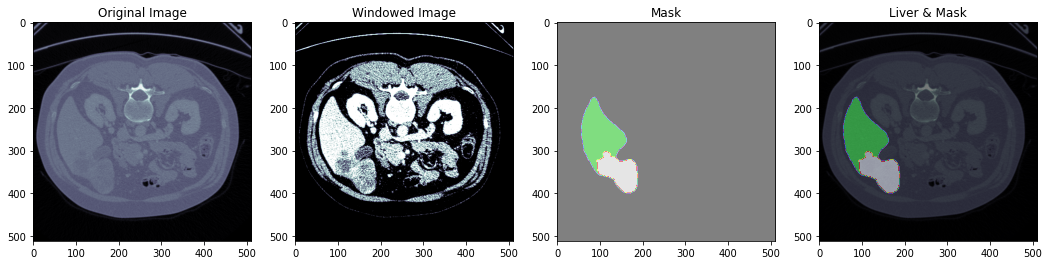

In [65]:
# test number
tst = 3

# slice number
test_slice_idx = 450


test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [66]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

[TensorImage([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[29, 52, 68,  ..., 47, 24, 23],
         [18, 35, 70,  ..., 19, 13, 26],
         [52, 23, 41,  ..., 18, 19, 15],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]], dtype=torch.uint8)]
Number of test slices:  1


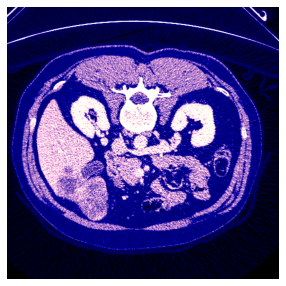

In [67]:
# Check an input for a test file
show_image(test_files[0])

<class 'fastai.torch_core.TensorBase'>


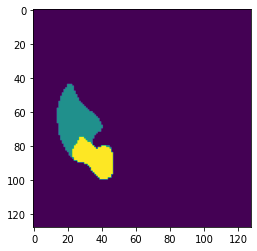

In [68]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds,y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
print(type(predicted_mask))
plt.imshow(predicted_mask[0])

In [69]:
a=np.array(predicted_mask[0])

unique, counts = np.unique(a, return_counts=True)
print( np.array((unique, counts)).T)

np.amin(a),np.amax(a),

[[    0 15401]
 [    1   615]
 [    2   368]]


(0, 2)

### Getting predictions done on multiple images.

../input/trained-model

  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0 1]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1 2]
actual: [0 1 2]


curr slice: 420
predicted [0 1]
actual: [0 1 2]


curr slice: 430
predicted [0 1 2]
actual: [0 1 2]


curr slice: 440
predicted [0 1 2]
actual: [0 1 2]


curr slice: 450
predicted [0 1 2]
actual: [0 1 2]


curr slice: 460
predicted [0 1 2]
actual: [0 1 2]


curr slice: 470
predicted [0 1 2]
actual: [0 1 2]


curr slice: 480
predicted [0 1 2]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1 2]


curr slice: 540
predicted [0 1 2]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0 1]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1 2]
actual: [0 1 2]


curr slice: 420
predicted [0 1 2]
actual: [0 1 2]


curr slice: 430
predicted [0 1 2]
actual: [0 1 2]


curr slice: 440
predicted [0 1 2]
actual: [0 1 2]


curr slice: 450
predicted [0 1 2]
actual: [0 1 2]


curr slice: 460
predicted [0 1 2]
actual: [0 1 2]


curr slice: 470
predicted [0 1 2]
actual: [0 1 2]


curr slice: 480
predicted [0 1 2]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1 2]


curr slice: 540
predicted [0 1 2]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0 1]
actual: [0 1]


curr slice: 390
predicted [0 1]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1]
actual: [0 1]


curr slice: 420
predicted [0 1]
actual: [0 1]


curr slice: 430
predicted [0 1]
actual: [0 1]


curr slice: 440
predicted [0 1]
actual: [0 1]


curr slice: 450
predicted [0 1]
actual: [0 1]


curr slice: 460
predicted [0 1]
actual: [0 1]


curr slice: 470
predicted [0 1]
actual: [0 1]


curr slice: 480
predicted [0 1]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1]
actual: [0 1]


curr slice: 540
predicted [0 1]
actual: [0 1]
[[31  0]
 [ 2 57]]


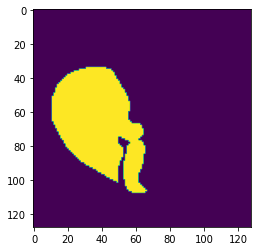

In [70]:

def nii_tfm_selctive(fn,wins,curr_slice): 
    slices = []
    test_nii  = read_nii(fn)
    data = tensor(test_nii[...,curr_slice].astype(np.float32))
    data = (data.to_nchan(wins)*255).byte()
    slices.append(TensorImage(data))
    return slices

def check(img):
    cnt,h = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) > 0:
        return 1
    else:
        return 0
    

nums = [3,4,5]
vol_names = ['volume-100.nii','volume-102.nii','volume-102.nii']
seg_names = ['segmentation-100.nii','segmentation-102.nii','segmentation-102.nii']


conf_matrix =  np.zeros((2,2),dtype = int)


for nums,vol_names,seg_names in zip(nums,vol_names,seg_names):
    curr_mask      = read_nii(df_files.loc[nums,'mask_dirname']+"/"+df_files.loc[nums,'mask_filename'])
    for curr_slice in tqdm(range(250,550,10)): # export every 10th slice for testing
        
        # for prediction
        test_file = nii_tfm_selctive(df_files.loc[nums,'dirname']+"/"+df_files.loc[nums,'filename'],[dicom_windows.liver, dicom_windows.custom],curr_slice)
        test_dl = learn0.dls.test_dl(test_file)
        preds, y = learn0.get_preds(dl=test_dl)
        
        predicted_mask = np.argmax(preds, axis=1)# getting the predicted mask
        plt.imshow(predicted_mask[0])
        a=np.array(predicted_mask[0])
        
        tumor_p = False
        
        print('curr slice:',curr_slice)
        
        unique = np.unique(a)
        print("predicted",unique)
        if 0 in unique:
            back_p = True
        else:
            back_p = False
        if 1 in unique:
            liver_p = True
        else:
            liver_p = False
        if 2 in unique:
            tumor_p = True
        else:
            tumor_p = False
        

        # for getiing the actual mask values
        mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
        tumor_t = False
        
        unique = np.unique(mask)
        print("actual:",unique)
        if 0 in unique:
            back_t = True
        else:
            back_t = False
        if 1 in unique:
            liver_t = True
        else:
            liver_t = False
        if 2 in unique:
            tumor_t = True
        else:
            tumor_t = False
            
        # populating the conf_matrix
        if tumor_p == True and tumor_t == True:
            conf_matrix[0,0] += 1
        if tumor_p == False and tumor_t == False:
            conf_matrix[1,1] += 1
        if tumor_p == False and tumor_t == True:
            conf_matrix[1,0] += 1
        if tumor_p == True and tumor_t == False:
            conf_matrix[0,1] += 1
            
        
print(conf_matrix)
            

# Plot Confusion Matrix

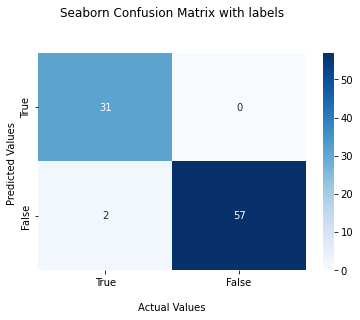

In [71]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Converting the `.nii` files to jpg and converting the corresponding mask.
### This will later be used for validating the model

In [72]:
 # Converting the .nii files to jpg and converting the corresponding mask
nums = [3,4,5]
vol_names = ['volume-100.nii','volume-102.nii','volume-102.nii']
seg_names = ['segmentation-100.nii','segmentation-102.nii','segmentation-102.nii']
total_slice = 0
# print(df_files.loc[nums,'dirname']+"/"+df_files.loc[nums,'filename'])
for nums,vol_names,seg_names in zip(nums,vol_names,seg_names):
    curr_ct = read_nii(df_files.loc[nums,'dirname']+"/"+df_files.loc[nums,'filename'])
    curr_mask = read_nii(df_files.loc[nums,'mask_dirname']+"/"+df_files.loc[nums,'mask_filename']) 
    curr_file_name = str(df_files.loc[nums,'filename']).split('.')[0]
    curr_dim = curr_ct.shape[2] # 512, 512, curr_dim
    for curr_slice in tqdm(range(250,550,10)): # export every 10th slice for testing
        data = tensor(curr_ct[...,curr_slice].astype(np.float32))
        mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L") 
        data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
        mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.jpg")
        total_slice = total_slice+1 
print(total_slice)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

90


#### Using opencv to find if the mask of an scan image is showing any of the features (background,liver and tumor). The data is being saved into a csv files. This can later be used to validate the model by comparing the model prediction with the csv files.

In [73]:
import cv2 
import numpy as np
import os


def check(img):
    cnt,h = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) > 0:
        return 1
    else:
        return 0

f = open('true_values.csv',mode = 'w')

file_iterator = os.scandir('./train_masks')
for i in file_iterator:
    
    img = cv2.imread("./train_masks/"+i.name,-1)
    print(img.shape)
    
    # if only the background is visible
    if np.count_nonzero(img)==0:
        f.write('0,0,0\n')
    else:
        f.write('0,')
        # for liver
        img_liver = np.where(img == 1, 255, img)
        img_liver = np.where(img_liver == 2, 0, img)
        ret = check(img_liver)
        if ret:
            f.write('1,')
        else:
            f.write('0,')

        # for tumor
        img_tumor = np.where(img == 2, 255, img)
        img_tumor = np.where(img_tumor == 1, 0, img)
        ret = check(img_tumor)
        if ret:
            f.write('1')
        else:
            f.write('0')

        f.write('\n')

f.close()

Streaming output truncated to the last 5000 lines.
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(51

In [ ]:
# Cross validatio